In [1]:
import torch
import pandas as pd
import torchtext
from torchtext import data
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import helpers
import importlib

Uncomment the line below to download the spaCy tokenizer if not already done so

In [2]:
#!python -m spacy download en

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torchtext.__version__)
print(torch.__version__)
print(device)
torch.backends.cudnn.deterministic = True

# constants
FILE_NAME = "training.1600000.processed.noemoticon.csv"
SUBSET_FILE_NAME = "data.csv"
N = 80000
SEED = 1
SPLIT_RATIO = [0.7, 0.15, 0.15]
MAX_VOCAB_SIZE = 30000
GLOVE_VECTORS = "glove.6B.100d"
GLOVE_DIM = 100
BATCH_SIZE = 128
PT_PATH = "saves"
EPOCHS=20
LR = 1e-3

torch.manual_seed(SEED)

0.6.0
2.1.1+cu118
cuda


## Data Preprocessing

In [4]:
df = pd.read_csv(FILE_NAME, header=None, engine="python", encoding="latin-1")
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


According the description from source page on [kaggle](https://www.kaggle.com/datasets/kazanova/sentiment140/data), there are 3 possible labels: "0 = negative, 2 = neutral, 4 = positive." As shown below however, the label has 2 possible values: `0` for negative sentiment and `1` for positive. The target is actually binary simplifying classification task.

In [5]:
print(df[0].value_counts())

# replace the values to 0 and 1
df[0] = df[0].replace(to_replace=4, value=1)

# sample the dataset and save the file
subset_df = df.sample(N, random_state=SEED)
subset_df.to_csv(SUBSET_FILE_NAME, header=None, index=None)

0
0    800000
4    800000
Name: count, dtype: int64


### Creating the Dataset
First, declare the text and label fields. By setting `include_lengths=True`, we will include a tensor containing the lengths of each sequence. 

In [6]:
TEXT = data.Field(tokenize='spacy', lower=True, include_lengths= True)
LABEL = data.LabelField(dtype=torch.float)

fields = [
    ('label', LABEL), 
    ('id', None),
    ('date', None),
    ('query', None),
    ('name', None), 
    ('text', TEXT),
    ('category',None)
]

dataset = data.TabularDataset(
    path=SUBSET_FILE_NAME,
    format="CSV",
    fields=fields,
    skip_header=False
)


In [7]:
# Split into train, test, validation sets
train_dataset, test_dataset, validation_dataset = dataset.split(split_ratio=SPLIT_RATIO)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

Train dataset size: 56000
Test dataset size: 12000
Validation dataset size: 12000


### Building the Vocab
The vocab will be built using pre-train [GloVe](https://nlp.stanford.edu/projects/glove/) embeddings. It is also important to note that the vocab should only be built using the test dataset. The `unk_init` parameter specifies the initialization method for the vectors of out-of-vocabulary (OOV) tokens. It will be set to use a normal distribution for the initialization of OOV token vectors.

In [8]:
TEXT.build_vocab(
    train_dataset, 
    max_size = MAX_VOCAB_SIZE,
    vectors = GLOVE_VECTORS,
    unk_init = torch.Tensor.normal_
)

LABEL.build_vocab(train_dataset)

#### Most Frequent Tokens in the Corpus

Text(0.5, 1.0, 'Top 10 Most Frequent Tokens')

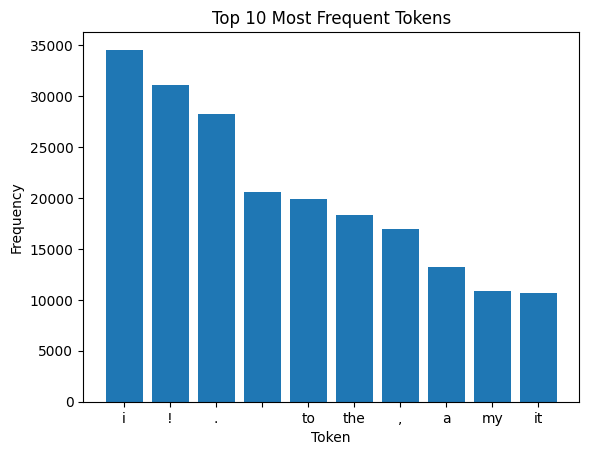

In [9]:
words, frequencies = zip(*TEXT.vocab.freqs.most_common(10))

plt.bar(words, frequencies)
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Tokens')

### Bucket Iterators
Text sequences will be grouped in batches based on similar lengths. Text sequences in a batch will all have the same length by applying padding. By batching sequences of similar lengths, minimal padding will be applied in each batch

In [10]:
train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits(
    (train_dataset, validation_dataset, test_dataset),
    device = device,
    batch_size = BATCH_SIZE,
    sort_key = lambda sample: len(sample.text),
    sort_within_batch = True
)

### What does our data look like?
Note that each batch will have sequences of the same length but different batches have differing sequence lengths.

In [11]:
for batch in train_iterator:
    (sequences, sequence_lengths), labels = batch.text, batch.label
    print("Length tensor shape:", sequence_lengths.shape)
    print("Text tensor shape:", sequences.shape)
    print("Labels tensor shape:", labels.shape)
    text_words = [train_iterator.dataset.fields['text'].vocab.itos[idx] for idx in sequences[0].tolist()]
    print("Text words:", text_words)
    print("Labels:", labels)
    break

Length tensor shape: torch.Size([128])
Text tensor shape: torch.Size([11, 128])
Labels tensor shape: torch.Size([128])
Text words: ['@wolfgang', '<unk>', '<unk>', 'man', '@pinkstwitfans', 'gone', 'the', '@ddlovato', 'ca', '<unk>', 'where', 'the', 'finally', 'i', '<unk>', '@anothera', '@', '@akbaramaru', 'just', '<unk>', 'a', 'hulu', 'great', '<unk>', '<unk>', 'babysitting', '@jeanneeee', 'welcome', '<unk>', '<unk>', 'going', '@debaucheddiva', 'done', 'go', 'i', 'i', 'just', 'slow', 'dinner', '<unk>', 'this', '@adrian_arevalo', '<unk>', 'road', '@sanaraset', 'i', '#', 'just', '@xsavedgex', '@dor33n', 'sore', '@reikifurbabies', 'science', '@dwears', '<unk>', '@jmibaby', 'omg', '<unk>', "'", '@katiberz', '<unk>', 'stuck', 'sick', 'non', 'i', '@iamthematrix', '@brentspiner', '<unk>', '@erincreed', 'am', '<unk>', 'crazy', '<unk>', 'i', '@dbhata', 'making', 'one', '<unk>', '<unk>', 'diet', '@fallenfrommars', '@illingsworth', '@katyand', 'missing', 'thanks', '@dlemoncomedy', '<unk>', '<unk>',

## RNN Model

In [12]:
import RNN
importlib.reload(RNN)

padding_idx = padding_idx=TEXT.vocab.stoi[TEXT.pad_token]
unknown_idx = padding_idx=TEXT.vocab.stoi[TEXT.unk_token]

model = RNN.Classifier(
    input_dim=len(TEXT.vocab),
    embedding_dim=GLOVE_DIM,
    hidden_dim=256,
    output_dim=1,
    rnn_layers=2,
    bidirectional=True,
    dropout_probability=0.5,
    padding_idx=padding_idx,
    name="RNN_model"
)

Copy the pre-trained word embedding into the embedding layer.

In [13]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.5256, -0.7502, -0.6540,  ...,  0.3434, -1.0703, -0.8743],
        [ 0.2053,  0.3051,  0.5357,  ..., -0.4203,  0.2828,  0.3642],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 0.6114, -2.6009, -1.2161,  ..., -0.1871,  0.2711,  0.7207],
        [ 0.2286,  0.8906, -0.8506,  ...,  0.9659, -0.8778,  0.7872],
        [ 0.1070,  0.5485, -0.7177,  ...,  0.9331,  0.7424,  0.6534]])

Set the `<unk>` and `<pad>` tokens to have zero weights as they do not benefit the task.

In [14]:
model.embedding.weight.data[padding_idx] = torch.zeros(GLOVE_DIM)
model.embedding.weight.data[unknown_idx] = torch.zeros(GLOVE_DIM)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

### Train and Validation Loops

In [16]:
def train(model, iterator, optimizer, criterion):
    total_loss = 0.0
    total_accuracy = 0.0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        sequences, true_lengths = batch.text
        predictions = model(sequences, true_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        accuracy = helpers.get_accuracy(predictions, batch.label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += accuracy.item()
    return total_loss / len(iterator), total_accuracy / len(iterator)

def evaluate(model, iterator, criterion):
    total_loss = 0.0
    total_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            accuracy = helpers.get_accuracy(predictions, batch.label)
            total_loss += loss.item()
            total_accuracy += accuracy.item()
    return total_loss / len(iterator), total_accuracy / len(iterator)

In [17]:
train_accuracies, validation_accuraies = helpers.train_loop(
    train_fn=train,
    evaluate_fn=evaluate,
    model=model,
    train_iterator=train_iterator,
    validation_iterator=validation_iterator,
    optimizer=optimizer,
    criterion=criterion,
    epochs=EPOCHS,
    check_point_path=PT_PATH
)

Epoch 1 | Elapsed: 0:00:04.623356
Train Loss 0.62 | Train Accuracy: 65.41%
Validation Loss 0.54 | Validation Accuracy: 72.77%

Epoch 2 | Elapsed: 0:00:04.313904
Train Loss 0.55 | Train Accuracy: 72.50%
Validation Loss 0.55 | Validation Accuracy: 75.18%

Epoch 3 | Elapsed: 0:00:04.232009
Train Loss 0.52 | Train Accuracy: 74.73%
Validation Loss 0.5 | Validation Accuracy: 75.97%

Epoch 4 | Elapsed: 0:00:04.240434
Train Loss 0.49 | Train Accuracy: 77.09%
Validation Loss 0.48 | Validation Accuracy: 77.20%

Epoch 5 | Elapsed: 0:00:04.228546
Train Loss 0.47 | Train Accuracy: 78.12%
Validation Loss 0.48 | Validation Accuracy: 77.26%

Epoch 6 | Elapsed: 0:00:04.255216
Train Loss 0.45 | Train Accuracy: 79.42%
Validation Loss 0.47 | Validation Accuracy: 77.77%

Epoch 7 | Elapsed: 0:00:04.232427
Train Loss 0.44 | Train Accuracy: 79.79%
Validation Loss 0.49 | Validation Accuracy: 77.15%

Epoch 8 | Elapsed: 0:00:04.279447
Train Loss 0.43 | Train Accuracy: 80.60%
Validation Loss 0.49 | Validation Acc

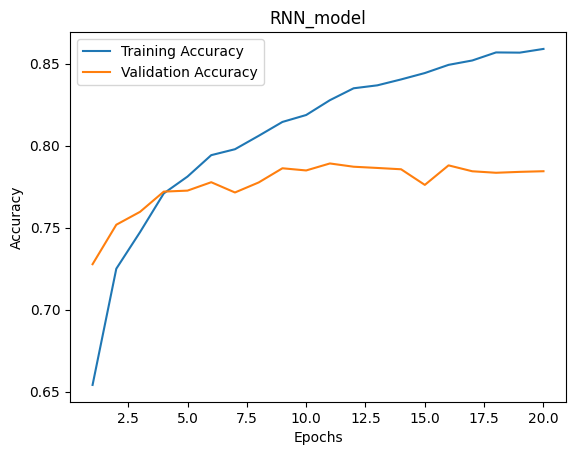

In [18]:
helpers.plot_learning_curves(train_accuracies, validation_accuraies, model.name)

## LSTM Model

In [19]:
import LSTM
importlib.reload(LSTM)

padding_idx = padding_idx=TEXT.vocab.stoi[TEXT.pad_token]
unknown_idx = padding_idx=TEXT.vocab.stoi[TEXT.unk_token]

model2 = LSTM.Classifier(
    input_dim=len(TEXT.vocab),
    embedding_dim=GLOVE_DIM,
    hidden_dim=256,
    output_dim=1,
    lstm_layers=2,
    bidirectional=True,
    dropout_probability=0.5,
    padding_idx=padding_idx,
    name="LSTM_model"
)

pretrained_embeddings = TEXT.vocab.vectors
model2.embedding.weight.data.copy_(pretrained_embeddings)

model2.embedding.weight.data[padding_idx] = torch.zeros(GLOVE_DIM)
model2.embedding.weight.data[unknown_idx] = torch.zeros(GLOVE_DIM)

optimizer = optim.Adam(model2.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

model2 = model2.to(device)
criterion = criterion.to(device)

In [20]:
train_accuracies, validation_accuraies = helpers.train_loop(
    train_fn=train,
    evaluate_fn=evaluate,
    model=model2,
    train_iterator=train_iterator,
    validation_iterator=validation_iterator,
    optimizer=optimizer,
    criterion=criterion,
    epochs=EPOCHS,
    check_point_path=PT_PATH
)

Epoch 1 | Elapsed: 0:00:06.889769
Train Loss 0.57 | Train Accuracy: 69.56%
Validation Loss 0.48 | Validation Accuracy: 76.57%

Epoch 2 | Elapsed: 0:00:06.820792
Train Loss 0.48 | Train Accuracy: 77.34%
Validation Loss 0.44 | Validation Accuracy: 79.06%

Epoch 3 | Elapsed: 0:00:06.855673
Train Loss 0.44 | Train Accuracy: 79.67%
Validation Loss 0.43 | Validation Accuracy: 80.37%

Epoch 4 | Elapsed: 0:00:06.843733
Train Loss 0.41 | Train Accuracy: 81.47%
Validation Loss 0.42 | Validation Accuracy: 80.86%

Epoch 5 | Elapsed: 0:00:06.802847
Train Loss 0.39 | Train Accuracy: 82.76%
Validation Loss 0.42 | Validation Accuracy: 81.03%

Epoch 6 | Elapsed: 0:00:06.789232
Train Loss 0.36 | Train Accuracy: 84.03%
Validation Loss 0.42 | Validation Accuracy: 81.05%

Epoch 7 | Elapsed: 0:00:06.763078
Train Loss 0.34 | Train Accuracy: 85.10%
Validation Loss 0.43 | Validation Accuracy: 81.32%

Epoch 8 | Elapsed: 0:00:06.802701
Train Loss 0.32 | Train Accuracy: 86.26%
Validation Loss 0.44 | Validation Ac

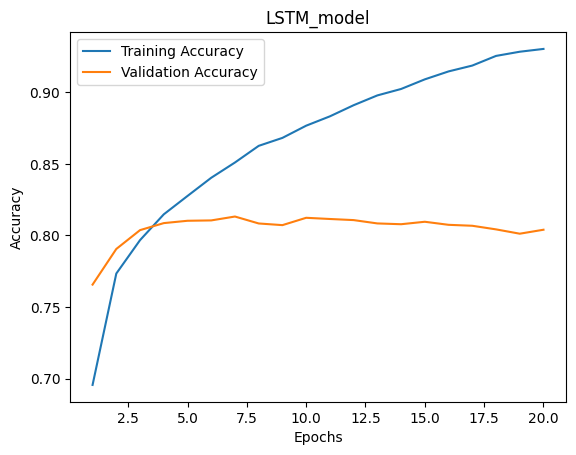

In [21]:
helpers.plot_learning_curves(train_accuracies, validation_accuraies, model2.name)

# Compare the models

In [22]:
a, b = helpers.compare_best(PT_PATH, model, model2, evaluate, test_iterator, criterion)
print(f"Model {model.name} test accuracy: {a}")
print(f"Model {model2.name} test accuracy: {b}")

Model RNN_model test accuracy: 0.7887577573035626
Model LSTM_model test accuracy: 0.8051307626227115
